# 12. PPO Algo

## 12.1. Intro

回忆
TRPO:
$$
\max_\theta \mathbb{E}_{s \sim v^{\pi_{\theta_k}}}\mathbb{E}_{a \sim \pi_{\theta_k}(\cdot | s)} [\frac{\pi_{\theta'}(a | s)}{\pi_{\theta_k}(a|s)}A^{\pi_{\theta_k}}(s, a)] \\
s.t. \mathbb{E}_{s \sim v^{\pi_{\theta_k}}}[D_{KL}(\pi_{\theta_k}(\cdot | s), \pi_{\theta}(\cdot | s))] \leq \delta
$$

## 12.2. PPO-Penalty

$$
\argmax_\theta \mathbb{E}_{s \sim v^{\pi_{\theta_k}}}\mathbb{E}_{a \sim \pi_{\theta_k}(\cdot | s)}[\frac{\pi_{\theta'}(a | s)}{\pi_{\theta_k}(a|s)}A^{\pi_{\theta_k}}(s, a) - \beta D_{KL}(\pi_{\theta_k}(\cdot | s), \pi_{\theta}(\cdot | s))]
$$

令$d_k = D_{KL}^{v^{\pi_{\theta_k}}}(\pi_{\theta_k}, \pi_\theta)$, $\beta$的更新规则留下：
1. $d_k < \delta / 1.5$, $\beta_{k+1} = \beta_k / 2$
2. $d_k > \delta \times 1.5$, $\beta_{k+1} = \beta_k \times 2$
3. 否则$\beta_{k + 1} = \beta_k$

## 12.3. PPO-Clip

$$
\argmax_\theta \mathbb{E}_{s \sim \nu^{\pi_{\theta_k}}}\mathbb{E}_{a \sim \pi_{\theta_k}(\cdot | s)}\left[\min\left(\frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a | s)}A^{\pi_{\theta_k}}(s, a), \text{clip}(\frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a | s)}, 1 - \epsilon, 1 + \epsilon)A^{\pi_{\theta_k}}(s, a)\right)\right]
$$

## 12.4. PPO implements

In [19]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
if not hasattr(np, "bool8"):
  np.bool8 = np.bool_ # 这样写np不用降级
import matplotlib.pyplot as plt
import rl_utils

class PolicyNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(PolicyNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    return F.softmax(self.fc2(x), dim=1)
  
class ValueNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim):
    super(ValueNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, 1)
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    return self.fc2(x)
  
class PPO:
  """ PPO算法,采用截断方式 """
  def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, 
              lmbda, epochs, eps, gamma, device):
    self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
    self.critic = ValueNet(state_dim, hidden_dim).to(device)
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    self.gamma = gamma
    self.lmbda = lmbda
    self.epochs = epochs # 训练轮数
    self.eps = eps # PPO阶段范围的参数
    self.device = device
    
  def take_action(self, state):
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    probs = self.actor(state)
    action_dist = torch.distributions.Categorical(probs)
    action = action_dist.sample()
    return action.item()
  
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
    td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones) 
    td_delta = td_target - self.critic(states)
    advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
    old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
    
    for _ in range(self.epochs):
      log_probs = torch.log(self.actor(states).gather(1, actions))
      ratio = torch.exp(log_probs - old_log_probs)
      surr1 = ratio * advantage
      surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage # 截断
      actor_loss = torch.mean(-torch.min(surr1, surr2)) # PPO损失函数  
      critic_loss = torch.mean(
        F.mse_loss(self.critic(states), td_target.detach())
      )
      self.actor_optimizer.zero_grad()
      self.critic_optimizer.zero_grad()
      actor_loss.backward()
      critic_loss.backward()
      self.actor_optimizer.step()
      self.critic_optimizer.step()

In [20]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name= "CartPole-v1"
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent,num_episodes)

Iteration 9: 100%|██████████| 50/50 [00:11<00:00,  4.49it/s, episode=500, return=496.200]


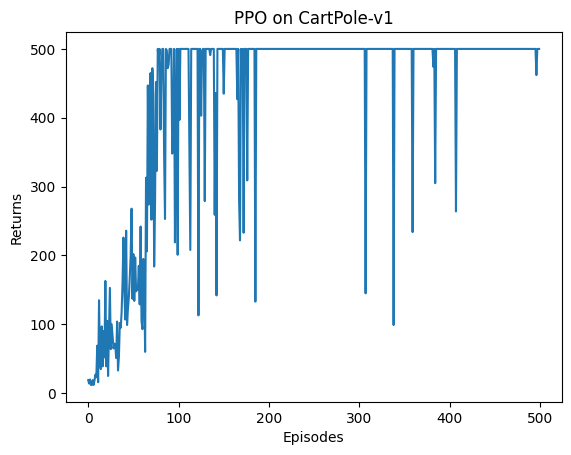

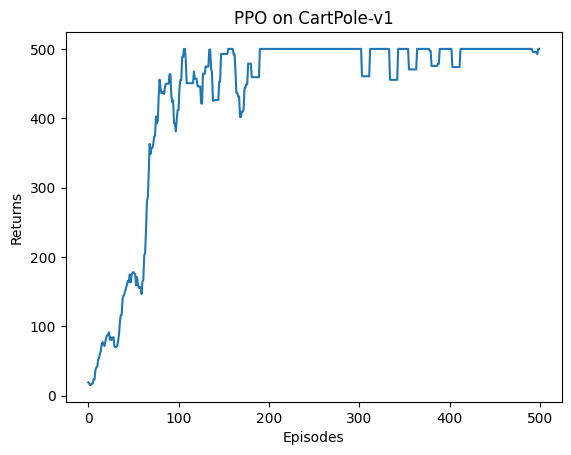

In [22]:
episode_list = list(range(len(return_list)))
plt.plot(episode_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episode_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [23]:
class PolicyNetContinuous(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(PolicyNetContinuous, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
    self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    mu = 2.0 * torch.tanh(self.fc_mu(x))
    std = F.softplus(self.fc_std(x))
    return mu, std
  
class PPOContinuous:
  """ PPO算法,采用截断方式 """
  def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, 
              lmbda, epochs, eps, gamma, device):
    self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
    self.critic = ValueNet(state_dim, hidden_dim).to(device)
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    self.gamma = gamma
    self.lmbda = lmbda
    self.epochs = epochs # 训练轮数
    self.eps = eps # PPO阶段范围的参数
    self.device = device
    
  def take_action(self, state):
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    mu, sigma = self.actor(state)
    action_dist = torch.distributions.Normal(mu, sigma)
    action = action_dist.sample()
    return [action.item()]
  
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
    rewards = (rewards + 8.0) / 8.0 # 和TRPO一样,对奖励进行修改,方便训练
    td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones) 
    td_delta = td_target - self.critic(states)
    advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
    mu, std = self.actor(states)
    action_dists = torch.distributions.Normal(mu.detach(), std.detach())
    # 动作正态分布
    old_log_probs = action_dists.log_prob(actions)
    
    for _ in range(self.epochs):
      mu, std = self.actor(states)
      action_dists = torch.distributions.Normal(mu, std)
      log_probs = action_dists.log_prob(actions)
      ratio = torch.exp(log_probs - old_log_probs)
      surr1 = ratio * advantage
      surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage # 截断
      actor_loss = torch.mean(-torch.min(surr1, surr2)) # PPO损失函数  
      critic_loss = torch.mean(
        F.mse_loss(self.critic(states), td_target.detach())
      )
      self.actor_optimizer.zero_grad()
      self.critic_optimizer.zero_grad()
      actor_loss.backward()
      critic_loss.backward()
      self.actor_optimizer.step()
      self.critic_optimizer.step()

In [25]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name= "Pendulum-v1"
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] # 连续动作空间
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent,num_episodes)

Iteration 9: 100%|██████████| 200/200 [00:22<00:00,  8.72it/s, episode=2000, return=-430.152]


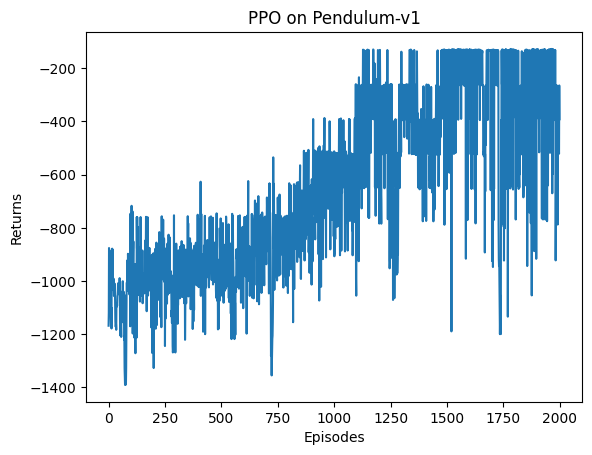

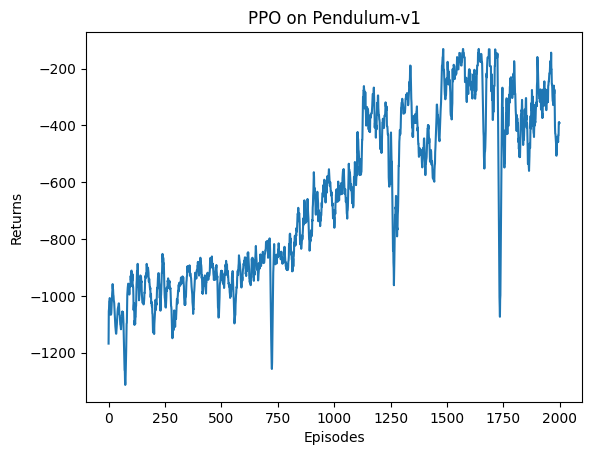

In [26]:
episode_list = list(range(len(return_list)))
plt.plot(episode_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episode_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()